# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (UTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs): #data_uti_incdt, data_uti_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_uti_admitted',
            event_col='event_uti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_uti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_uti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #save and print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_no', #'flu_vaccine_yes', 
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_east', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_yorkshire', 
                                   'imd_very_unaffluent', 'imd_unaffluent', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_medium', 
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_ex_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_smoker', 
                                   'season_autumn', 'season_spring', 'season_summer', #'season_winter', 
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [10]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [11]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

In [12]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [13]:
#process 20 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)
data_uti_13 = proc_infec_data(data,13)
data_uti_14 = proc_infec_data(data,14)
data_uti_15 = proc_infec_data(data,15)
data_uti_16 = proc_infec_data(data,16)
data_uti_17 = proc_infec_data(data,17)
data_uti_18 = proc_infec_data(data,18)
data_uti_19 = proc_infec_data(data,19)
data_uti_20 = proc_infec_data(data,20)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12, data_uti_13, data_uti_14, data_uti_15, data_uti_16, data_uti_17, data_uti_18, data_uti_19, data_uti_20])
data_uti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [14]:
##add variable season
#convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] 
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

In [15]:
#add variable time period
data_uti.loc[(data_uti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_uti.loc[((data_uti['date'] >= '2020-01') & (data_uti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_uti.loc[(data_uti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [16]:
data_uti['date'].max()

'2023-04'

#### event and duration

In [17]:
#scenario 1
#not hosped (nothing happened)
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0

In [18]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]

In [19]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [20]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30

#give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

In [21]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [22]:
#drop anybody with age less than 18 or 0!
data_uti = data_uti[~(data_uti['age'] < 18)] 
data_uti['age'][data_uti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

In [23]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking": dict_smoking})

In [24]:
#drop rows with missing region
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
   data_uti = data_uti[data_uti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_uti.columns) and (data_uti['smoking'].isnull().sum() > 0):
    data_uti['smoking'] = data_uti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    data_uti['imd'] = data_uti['imd'].fillna(0)

In [25]:
#missing values of bmi assign 5 and 0; categorise bmi
data_uti['bmi_cat'] = 5

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 30:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 25) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 30):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 18.5) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 25):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 18.5:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

In [26]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])
#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [27]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking": dict_smoking})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})

In [28]:
data_uti.ethnicity.value_counts('NA')

white      0.600041
unknown    0.251858
asian      0.074111
other      0.073989
Name: ethnicity, dtype: float64

In [29]:
data_uti.smoking.value_counts('NA')

unknown         0.416099
smoker          0.389771
never_smoked    0.128150
ex_smoker       0.065980
Name: smoking_status, dtype: float64

In [30]:
data_uti.bmi_cat.value_counts('NA')

obese             0.516079
unknown           0.257605
overweight        0.111490
healthy_weight    0.082989
underweight       0.031837
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [31]:
#categorise CCI
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

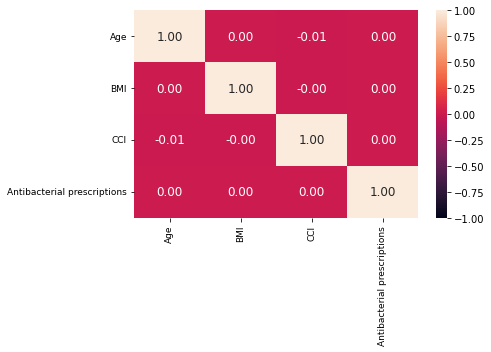

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [33]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date', 'period',
                                   'event_uti_admitted', 'duration_uti_admitted'
                                    ]]

In [34]:
#switch variable uti_ab_date into a binary variable
data_uti[['ab_binary']] = data_uti[['uti_ab_date']].where(data_uti[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]

#no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti_incdt[data_uti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti_incdt[data_uti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti_prevl[data_uti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti_prevl[data_uti_prevl['ab_binary'] == 1]

In [35]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['period'] == 'prepandemic']
data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['period'] == 'during_pandemic')]
data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['period'] == 'post_2nd_lockdown']
data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['period'] == 'prepandemic']
data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['period'] == 'during_pandemic')]
data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_uti_no_abs_incdt_prepandemic = data_uti_incdt_prepandemic[data_uti_incdt_prepandemic['ab_binary'] == 0]
data_uti_no_abs_incdt_during_pandemic = data_uti_incdt_during_pandemic[data_uti_incdt_during_pandemic['ab_binary'] == 0]
data_uti_no_abs_incdt_post_2nd_lockdown = data_uti_incdt_post_2nd_lockdown[data_uti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_uti_no_abs_prevl_prepandemic = data_uti_prevl_prepandemic[data_uti_prevl_prepandemic['ab_binary'] == 0]
data_uti_no_abs_prevl_during_pandemic = data_uti_prevl_during_pandemic[data_uti_prevl_during_pandemic['ab_binary'] == 0]
data_uti_no_abs_prevl_post_2nd_lockdown = data_uti_prevl_post_2nd_lockdown[data_uti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [36]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [37]:
#make summary tables
make_summary_table('uti', 'no_abs_incdt', data_uti_no_abs_incdt)
make_summary_table('uti', 'abs_incdt', data_uti_abs_incdt)
make_summary_table('uti', 'no_abs_prevl', data_uti_no_abs_prevl)
make_summary_table('uti', 'abs_prevl', data_uti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 109842 total observations, 109153 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 109842
number of events observed = 689
   partial log-likelihood = -7969.62
         time fit was run = 2023-07-10 09:24:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.12            -0.20             0.26                 0.82                 1.30
CCI_cat[T.medium]                0.11       1.12       0.13            -0.14             0.37                 0.87                 1.44
CCI_cat[T.high]                  0.19       1.21       0.15            -0.10             0.49                 0.91                 1.62
CCI_cat[T.very_high]             0.29       1.34       0.13             0.04             0.55                 1.04                 1.73
age_cat[T.25_34]                -0.08       0.92       0.14            -0.37             0.20                 0.69                 1.22
age_cat[T.35_44]                -0.12       0.88       0.15            -0.41             0.16                 0.66                 1.17
age_cat[T.45_54]                -0.04       0.96       0.14            -0.32             0.24                 0.73                 1.27
age_cat[T.55_64]                 0.02       1.02       0.14            -0.26             0.29                 0.77                 1.34
age_cat[T.65_74]                -0.05       0.96       0.14            -0.33             0.24                 0.72                 1.27
age_cat[T.75_more]               0.10       1.10       0.14            -0.18             0.37                 0.84                 1.44
antibacterial_brit              -0.08       0.93       0.03            -0.13            -0.02                 0.88                 0.98
bmi_cat[T.obese]                 0.22       1.25       0.15            -0.08             0.52                 0.92                 1.68
bmi_cat[T.overweight]            0.22       1.24       0.18            -0.14             0.57                 0.87                 1.77
bmi_cat[T.underweight]           0.10       1.10       0.27            -0.42             0.62                 0.65                 1.86
bmi_cat[T.unknown]               0.15       1.16       0.16            -0.17             0.47                 0.85                 1.60
ethnicity[T.other]              -0.09       0.92       0.19            -0.47             0.29                 0.63                 1.34
ethnicity[T.unknown]            -0.09       0.91       0.15            -0.39             0.21                 0.68                 1.24
ethnicity[T.white]              -0.10       0.90       0.14            -0.38             0.18                 0.68                 1.20
flu_vaccine[T.yes]              -0.02       0.98       0.13            -0.27             0.23                 0.76                 1.26
imd[T.medium]                   -0.05       0.96       0.12            -0.28             0.19                 0.75                 1.21
imd[T.unaffluent]               -0.02       0.98       0.12            -0.26             0.22                 0.77                 1.24
imd[T.unknown]                   0.03       1.03       0.18            -0.33             0.39                 0.72                 1.48
imd[T.very_affluent]            -0.12       0.89       0.12            -0.36             0.12                 0.70                 1.13
imd[T.very_unaffluent]          -0.18       0.84       0.13            -0.42             0.07                 0.65                 1.07
region[T.east_midlands]         -0.22       0.80       0.18        

13055


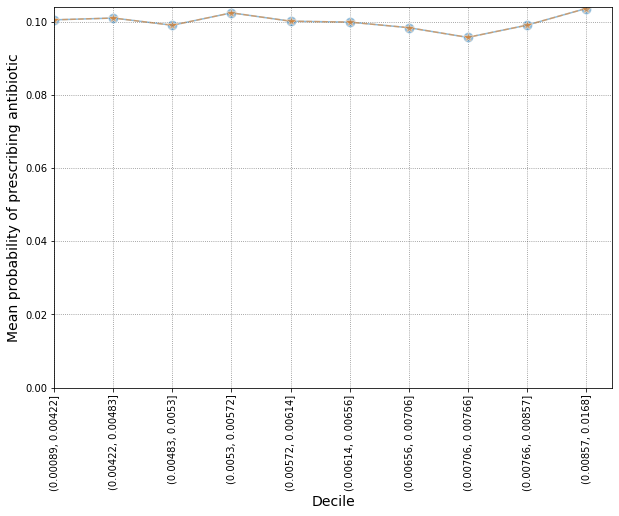


AUROC of LR for deciles with development and validation data: 0.50600 and 0.50390
AUROC of RF for deciles with development and validation data: 0.50838 and 0.49722
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00422, 0.00483]  0.114147  0.107657  0.121029
bins_(0.00483, 0.0053]   0.108051  0.101766  0.114725
bins_(0.0053, 0.00572]   0.116296  0.109733  0.123251
bins_(0.00572, 0.00614]  0.110808  0.104440  0.117564
bins_(0.00614, 0.00656]  0.111274  0.104872  0.118066
bins_(0.00656, 0.00706]  0.109393  0.103090  0.116082
bins_(0.00706, 0.00766]  0.104840  0.098689  0.111375
bins_(0.00766, 0.00857]  0.109711  0.103388  0.116420
bins_(0.00857, 0.0168]   0.114915  0.108412  0.121809

RF feature importance:
                           rf_coef
bins_(0.0053, 0.00572]   0.207858
bins_(0.00706, 0.00766]  0.198183
bins_(0.00857, 0.0168]   0.143502
bins_(0.00422, 0.00483]  0.118981
bins_(0.00483, 0.0053]   0.095857
bins_(0.00614, 0.00656]  0.065081
bins_(0.00572,

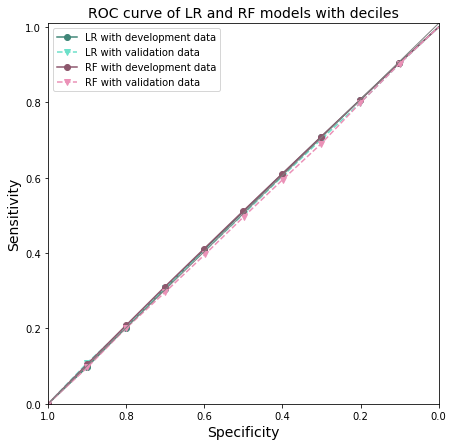

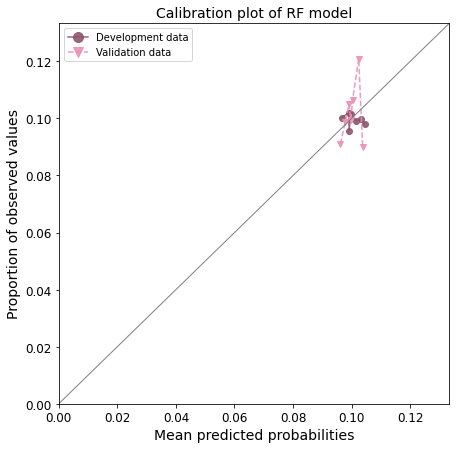

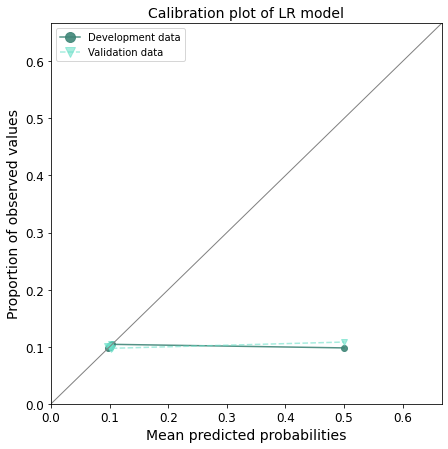


AUROC of LR for risk factors with development and validation data: 0.50966 and 0.49952
AUROC of RF for risk factors with development and validation data: 0.60198 and 0.49506
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_25_34                0.701436  0.657738  0.748037
age_cat_35_44                0.711271  0.666936  0.758553
age_cat_45_54                0.677975  0.635165  0.723669
age_cat_55_64                0.702407  0.658463  0.749284
age_cat_65_74                0.733123  0.687775  0.781462
age_cat_75_more              0.688149  0.644996  0.734189
sex_male                     0.942344  0.908362  0.977598
CCI_cat_high                 0.755869  0.704359  0.811145
CCI_cat_low                  0.791730  0.752794  0.832680
CCI_cat_medium               0.803869  0.759390  0.850954
CCI_cat_very_high            0.815641  0.768038  0.866195
flu_vaccine_no               0.660954  0.628717  0.694845
bmi_cat_obese                0.620506  0.587429  0.65

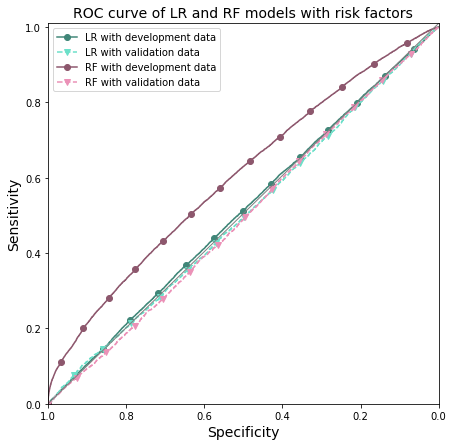

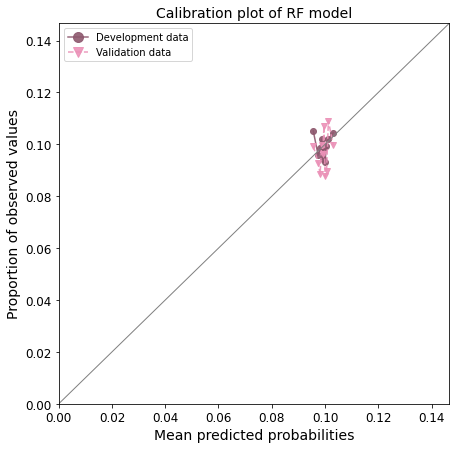

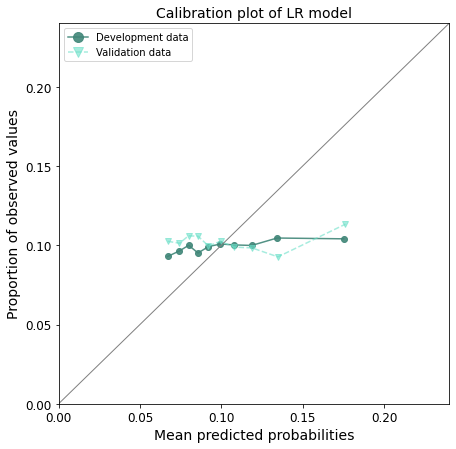

In [38]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt, prob_pred_uti_no_abs_incdt_bin = cox_build('uti', 'incdt', data_uti_incdt, data_uti_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('uti', 'incdt_deciles', prob_pred_uti_no_abs_incdt)

#make summary table of deciles
make_summary_table_deciles('uti', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('uti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('uti', 'incdt_riskfactors', prob_pred_uti_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('uti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12186 total observations, 12102 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 12186
number of events observed = 84
   partial log-likelihood = -773.23
         time fit was run = 2023-07-10 09:25:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.44       0.35            -0.32             1.04                 0.73                 2.84
CCI_cat[T.medium]               -0.26       0.77       0.43            -1.10             0.58                 0.33                 1.78
CCI_cat[T.high]                 -0.19       0.83       0.51            -1.19             0.80                 0.30                 2.24
CCI_cat[T.very_high]             0.65       1.92       0.37            -0.07             1.38                 0.93                 3.97
age_cat[T.25_34]                -0.51       0.60       0.44            -1.38             0.36                 0.25                 1.44
age_cat[T.35_44]                 0.13       1.14       0.37            -0.60             0.86                 0.55                 2.36
age_cat[T.45_54]                 0.09       1.10       0.38            -0.65             0.84                 0.52                 2.31
age_cat[T.55_64]                -0.38       0.68       0.43            -1.22             0.46                 0.29                 1.58
age_cat[T.65_74]                -0.03       0.97       0.39            -0.78             0.73                 0.46                 2.08
age_cat[T.75_more]              -0.17       0.84       0.40            -0.96             0.62                 0.38                 1.86
antibacterial_brit              -0.00       1.00       0.08            -0.15             0.15                 0.86                 1.16
bmi_cat[T.obese]                -0.17       0.84       0.39            -0.93             0.58                 0.39                 1.79
bmi_cat[T.overweight]           -0.05       0.95       0.48            -0.98             0.88                 0.37                 2.41
bmi_cat[T.underweight]          -0.00       1.00       0.68            -1.33             1.33                 0.26                 3.77
bmi_cat[T.unknown]              -0.19       0.83       0.42            -1.01             0.62                 0.37                 1.87
ethnicity[T.other]               0.38       1.46       0.47            -0.54             1.29                 0.58                 3.64
ethnicity[T.unknown]            -0.11       0.89       0.41            -0.92             0.70                 0.40                 2.01
ethnicity[T.white]              -0.30       0.74       0.39            -1.06             0.46                 0.35                 1.58
flu_vaccine[T.yes]              -0.35       0.71       0.42            -1.18             0.48                 0.31                 1.62
imd[T.medium]                   -0.08       0.92       0.37            -0.81             0.65                 0.44                 1.91
imd[T.unaffluent]               -0.32       0.73       0.40            -1.10             0.46                 0.33                 1.59
imd[T.unknown]                   0.71       2.03       0.44            -0.15             1.57                 0.86                 4.79
imd[T.very_affluent]            -0.19       0.82       0.38            -0.94             0.55                 0.39                 1.73
imd[T.very_unaffluent]           0.43       1.53       0.33            -0.23             1.08                 0.80                 2.94
region[T.east_midlands]         -0.81       0.45       0.60            -

13052


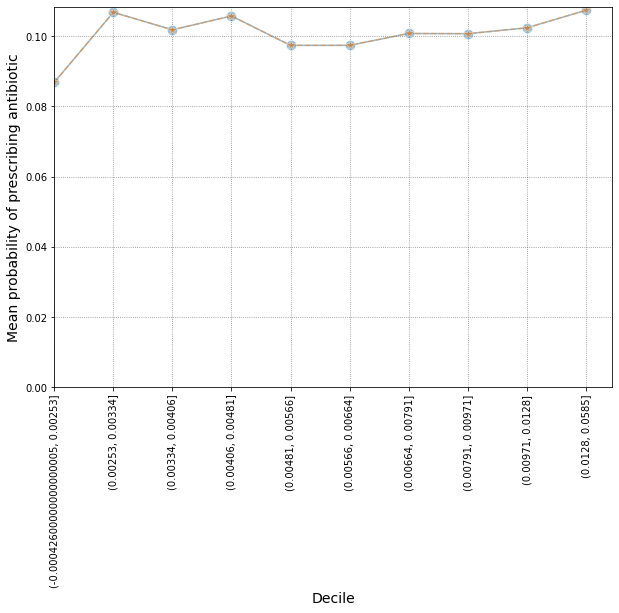


AUROC of LR for deciles with development and validation data: 0.51226 and 0.46330
AUROC of RF for deciles with development and validation data: 0.52682 and 0.48068
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00253, 0.00334]  0.132122  0.112040  0.155803
bins_(0.00334, 0.00406]  0.107518  0.089910  0.128575
bins_(0.00406, 0.00481]  0.127273  0.107624  0.150509
bins_(0.00481, 0.00566]  0.105611  0.088023  0.126712
bins_(0.00566, 0.00664]  0.101059  0.084017  0.121559
bins_(0.00664, 0.00791]  0.109047  0.091298  0.130246
bins_(0.00791, 0.00971]  0.113223  0.094887  0.135103
bins_(0.00971, 0.0128]   0.120264  0.101291  0.142789
bins_(0.0128, 0.0585]    0.114618  0.096107  0.136695

RF feature importance:
                           rf_coef
bins_(0.00253, 0.00334]  0.273348
bins_(0.00406, 0.00481]  0.172174
bins_(0.00971, 0.0128]   0.108584
bins_(0.00566, 0.00664]  0.095744
bins_(0.0128, 0.0585]    0.075415
bins_(0.00334, 0.00406]  0.071946
bins_(0.00481,

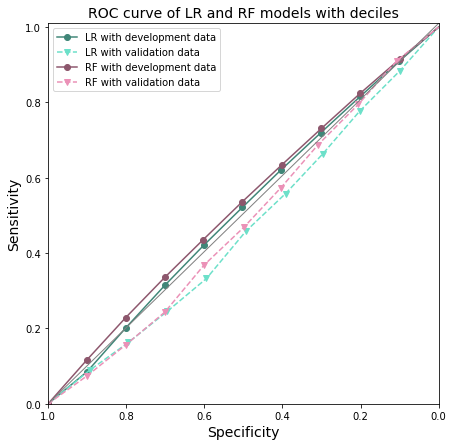

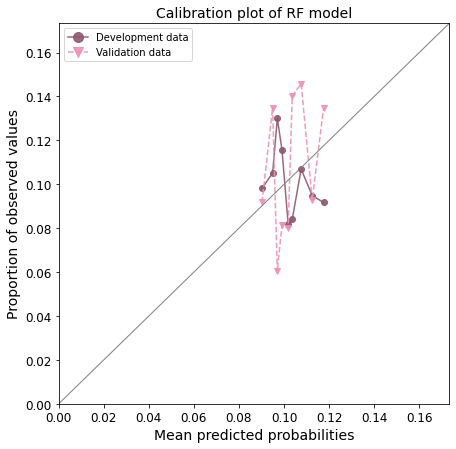

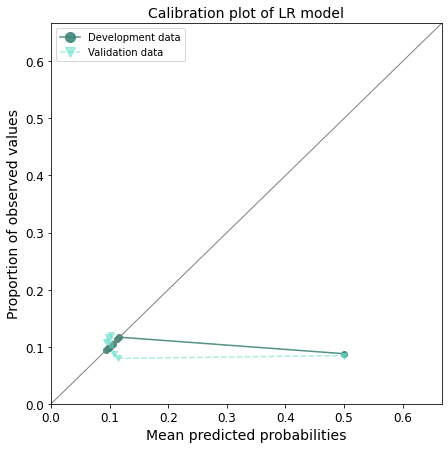


AUROC of LR for risk factors with development and validation data: 0.51210 and 0.47894
AUROC of RF for risk factors with development and validation data: 0.79427 and 0.50558
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_25_34                0.833592  0.689271  1.008132
age_cat_35_44                0.813941  0.671176  0.987075
age_cat_45_54                0.822082  0.677467  0.997567
age_cat_55_64                0.787555  0.648472  0.956467
age_cat_65_74                0.772672  0.634893  0.940350
age_cat_75_more              0.829249  0.684106  1.005186
sex_male                     0.820089  0.735121  0.914878
CCI_cat_high                 0.791752  0.642256  0.976046
CCI_cat_low                  0.838808  0.721532  0.975145
CCI_cat_medium               0.806815  0.679880  0.957448
CCI_cat_very_high            0.837912  0.700822  1.001818
flu_vaccine_no               0.683310  0.587566  0.794656
bmi_cat_obese                0.609632  0.517058  0.71

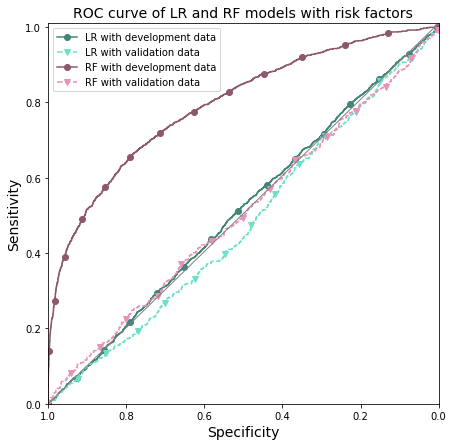

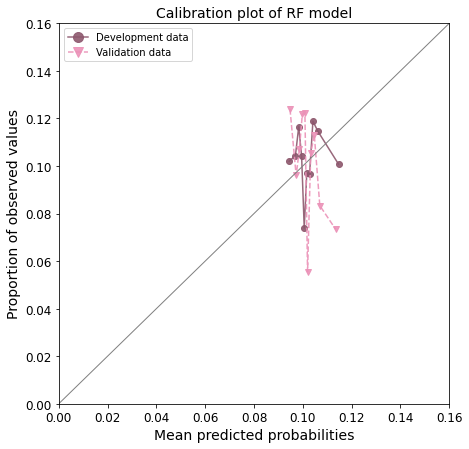

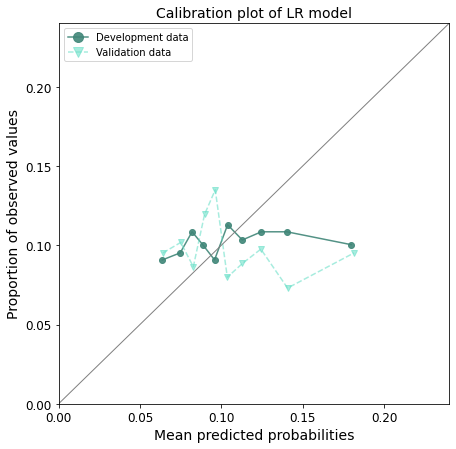

In [39]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl, prob_pred_uti_no_abs_prevl_bin = cox_build('uti', 'prevl', data_uti_prevl, data_uti_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('uti', 'prevl_deciles', prob_pred_uti_no_abs_prevl)

#make summary table of deciles
make_summary_table_deciles('uti', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('uti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('uti', 'prevl_riskfactors', prob_pred_uti_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('uti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28617 total observations, 28421 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 28617
number of events observed = 196
   partial log-likelihood = -1995.00
         time fit was run = 2023-07-10 09:25:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.22            -0.52             0.33                 0.60                 1.40
CCI_cat[T.medium]                0.03       1.03       0.24            -0.43             0.49                 0.65                 1.64
CCI_cat[T.high]                  0.06       1.07       0.28            -0.48             0.61                 0.62                 1.83
CCI_cat[T.very_high]             0.16       1.18       0.24            -0.31             0.63                 0.74                 1.89
age_cat[T.25_34]                -0.07       0.93       0.27            -0.59             0.45                 0.56                 1.57
age_cat[T.35_44]                -0.21       0.81       0.28            -0.75             0.34                 0.47                 1.40
age_cat[T.45_54]                 0.10       1.10       0.26            -0.40             0.60                 0.67                 1.83
age_cat[T.55_64]                 0.04       1.04       0.26            -0.47             0.55                 0.62                 1.73
age_cat[T.65_74]                -0.02       0.98       0.26            -0.54             0.49                 0.58                 1.63
age_cat[T.75_more]              -0.21       0.81       0.28            -0.75             0.33                 0.47                 1.39
antibacterial_brit              -0.10       0.91       0.05            -0.20             0.01                 0.82                 1.01
bmi_cat[T.obese]                 0.21       1.24       0.28            -0.34             0.77                 0.71                 2.17
bmi_cat[T.overweight]            0.12       1.12       0.35            -0.57             0.80                 0.57                 2.23
bmi_cat[T.underweight]           0.15       1.16       0.49            -0.80             1.11                 0.45                 3.03
bmi_cat[T.unknown]               0.23       1.25       0.30            -0.37             0.82                 0.69                 2.26
ethnicity[T.other]              -0.54       0.58       0.35            -1.22             0.14                 0.29                 1.15
ethnicity[T.unknown]            -0.69       0.50       0.26            -1.21            -0.17                 0.30                 0.84
ethnicity[T.white]              -0.43       0.65       0.23            -0.88             0.01                 0.42                 1.01
flu_vaccine[T.yes]               0.06       1.06       0.23            -0.40             0.51                 0.67                 1.67
imd[T.medium]                   -0.24       0.79       0.23            -0.68             0.21                 0.50                 1.24
imd[T.unaffluent]               -0.12       0.89       0.22            -0.55             0.31                 0.58                 1.37
imd[T.unknown]                   0.14       1.15       0.32            -0.48             0.76                 0.62                 2.13
imd[T.very_affluent]            -0.25       0.78       0.23            -0.70             0.20                 0.50                 1.22
imd[T.very_unaffluent]          -0.32       0.73       0.23            -0.78             0.13                 0.46                 1.14
region[T.east_midlands]          0.06       1.06       0.31           

13045


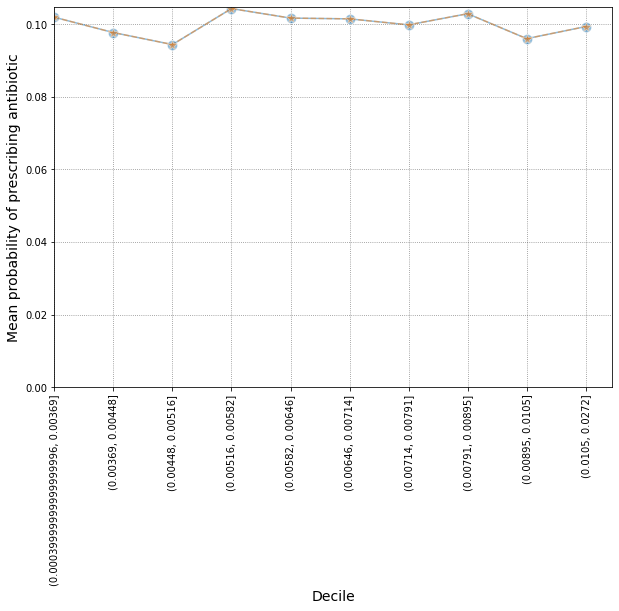


AUROC of LR for deciles with development and validation data: 0.51286 and 0.48834
AUROC of RF for deciles with development and validation data: 0.51378 and 0.48663
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00369, 0.00448]  0.103294  0.091737  0.116308
bins_(0.00448, 0.00516]  0.101279  0.089812  0.114210
bins_(0.00516, 0.00582]  0.119298  0.106609  0.133497
bins_(0.00582, 0.00646]  0.110211  0.098069  0.123857
bins_(0.00646, 0.00714]  0.114356  0.101957  0.128263
bins_(0.00714, 0.00791]  0.115143  0.102744  0.129038
bins_(0.00791, 0.00895]  0.119377  0.106626  0.133652
bins_(0.00895, 0.0105]   0.113398  0.101108  0.127183
bins_(0.0105, 0.0272]    0.111854  0.099614  0.125598

RF feature importance:
                           rf_coef
bins_(0.00448, 0.00516]  0.213255
bins_(0.00369, 0.00448]  0.179691
bins_(0.00516, 0.00582]  0.131492
bins_(0.00791, 0.00895]  0.124709
bins_(0.00714, 0.00791]  0.077547
bins_(0.0105, 0.0272]    0.073095
bins_(0.00582,

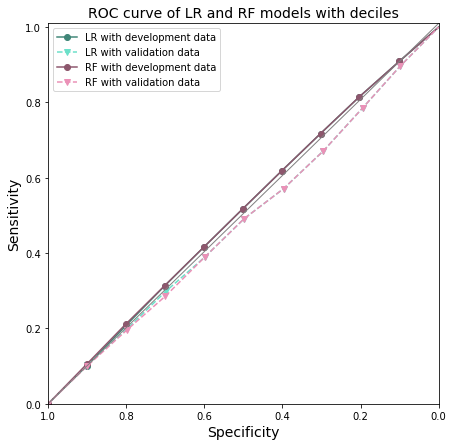

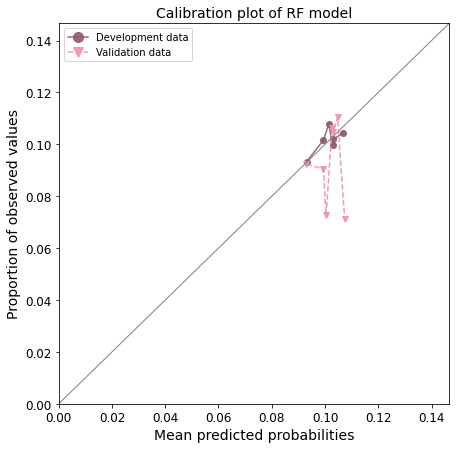

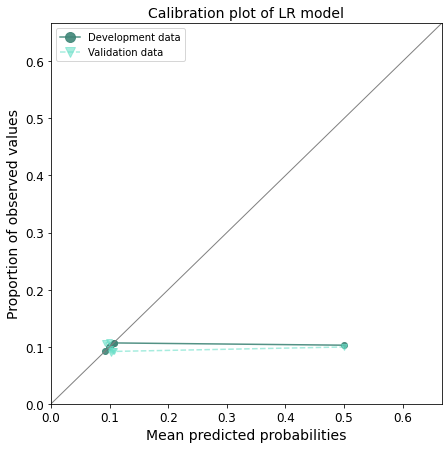

In [40]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt_prepandemic, prob_pred_uti_no_abs_incdt_prepandemic_bin = cox_build('uti', 'incdt_prepandemic', data_uti_incdt_prepandemic, data_uti_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('uti', 'incdt_prepandemic_deciles', prob_pred_uti_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 33093 total observations, 32888 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 33093
number of events observed = 205
   partial log-likelihood = -2108.32
         time fit was run = 2023-07-10 09:25:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.21            -0.46             0.37                 0.63                 1.45
CCI_cat[T.medium]                0.18       1.20       0.22            -0.26             0.62                 0.77                 1.85
CCI_cat[T.high]                  0.11       1.11       0.27            -0.42             0.63                 0.66                 1.88
CCI_cat[T.very_high]            -0.08       0.92       0.25            -0.57             0.41                 0.57                 1.50
age_cat[T.25_34]                 0.28       1.33       0.27            -0.25             0.82                 0.78                 2.27
age_cat[T.35_44]                -0.17       0.84       0.31            -0.77             0.43                 0.46                 1.53
age_cat[T.45_54]                 0.53       1.70       0.26             0.02             1.04                 1.02                 2.84
age_cat[T.55_64]                 0.02       1.02       0.29            -0.56             0.59                 0.57                 1.80
age_cat[T.65_74]                 0.14       1.15       0.28            -0.42             0.70                 0.66                 2.01
age_cat[T.75_more]               0.47       1.60       0.26            -0.05             0.99                 0.95                 2.68
antibacterial_brit               0.05       1.05       0.05            -0.05             0.14                 0.96                 1.15
bmi_cat[T.obese]                 0.24       1.27       0.28            -0.32             0.80                 0.73                 2.22
bmi_cat[T.overweight]           -0.05       0.95       0.36            -0.75             0.65                 0.47                 1.91
bmi_cat[T.underweight]           0.55       1.73       0.43            -0.29             1.38                 0.75                 3.99
bmi_cat[T.unknown]               0.26       1.30       0.30            -0.33             0.85                 0.72                 2.33
ethnicity[T.other]              -0.28       0.76       0.37            -1.00             0.45                 0.37                 1.56
ethnicity[T.unknown]            -0.02       0.98       0.28            -0.57             0.52                 0.57                 1.68
ethnicity[T.white]              -0.15       0.86       0.26            -0.66             0.36                 0.52                 1.44
flu_vaccine[T.yes]               0.28       1.32       0.21            -0.13             0.69                 0.88                 1.99
imd[T.medium]                    0.15       1.16       0.21            -0.26             0.56                 0.77                 1.74
imd[T.unaffluent]               -0.20       0.82       0.23            -0.64             0.25                 0.53                 1.29
imd[T.unknown]                   0.39       1.48       0.29            -0.19             0.96                 0.83                 2.62
imd[T.very_affluent]            -0.13       0.88       0.22            -0.56             0.31                 0.57                 1.36
imd[T.very_unaffluent]          -0.59       0.55       0.25            -1.09            -0.09                 0.34                 0.91
region[T.east_midlands]         -0.65       0.52       0.41           

13030


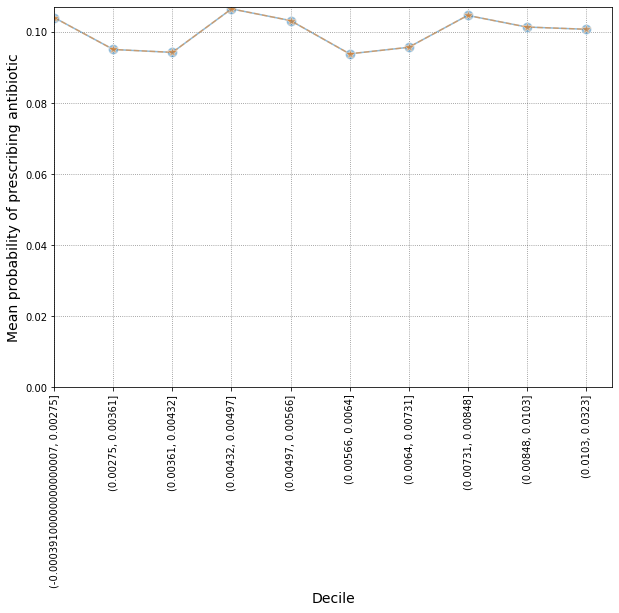


AUROC of LR for deciles with development and validation data: 0.51349 and 0.51116
AUROC of RF for deciles with development and validation data: 0.51456 and 0.50913
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00275, 0.00361]  0.100357  0.089724  0.112250
bins_(0.00361, 0.00432]  0.106331  0.095252  0.118700
bins_(0.00432, 0.00497]  0.117180  0.105425  0.130247
bins_(0.00497, 0.00566]  0.117359  0.105585  0.130447
bins_(0.00566, 0.0064]   0.105359  0.094340  0.117664
bins_(0.0064, 0.00731]   0.106829  0.095710  0.119239
bins_(0.00731, 0.00848]  0.118574  0.106886  0.131540
bins_(0.00848, 0.0103]   0.112816  0.101391  0.125528
bins_(0.0103, 0.0323]    0.115033  0.103417  0.127954

RF feature importance:
                           rf_coef
bins_(0.00275, 0.00361]  0.220292
bins_(0.00566, 0.0064]   0.115019
bins_(0.00432, 0.00497]  0.114138
bins_(0.00731, 0.00848]  0.111571
bins_(0.00497, 0.00566]  0.106535
bins_(0.00361, 0.00432]  0.098166
bins_(0.0064, 

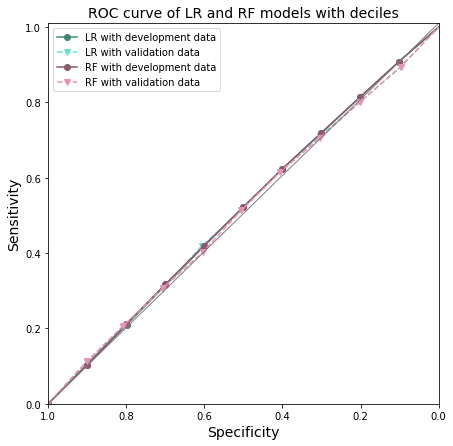

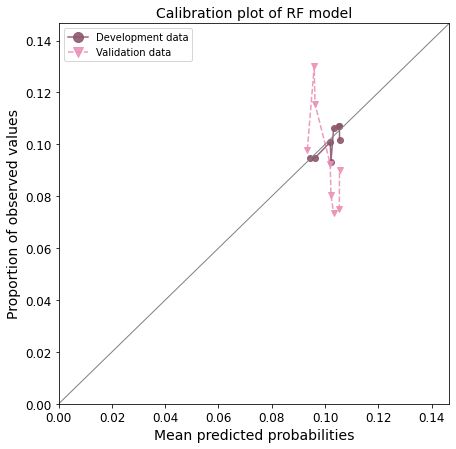

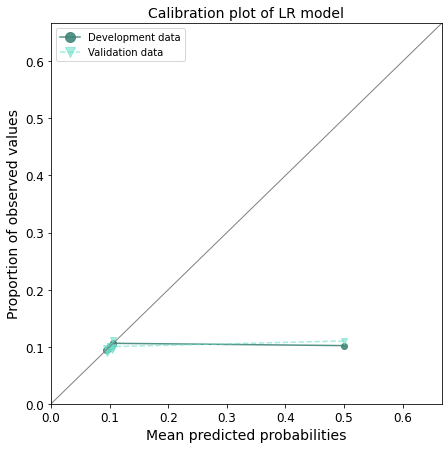

In [41]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt_during_pandemic, prob_pred_uti_no_abs_incdt_during_pandemic_bin = cox_build('uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic, data_uti_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('uti', 'incdt_during_pandemic_deciles', prob_pred_uti_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 48131 total observations, 47844 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 48131
number of events observed = 287
   partial log-likelihood = -3069.25
         time fit was run = 2023-07-10 09:25:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.11       1.12       0.19            -0.26             0.48                 0.77                 1.62
CCI_cat[T.medium]                0.10       1.10       0.21            -0.32             0.51                 0.73                 1.66
CCI_cat[T.high]                  0.40       1.49       0.23            -0.05             0.85                 0.95                 2.34
CCI_cat[T.very_high]             0.54       1.72       0.20             0.15             0.93                 1.16                 2.55
age_cat[T.25_34]                -0.13       0.88       0.22            -0.56             0.30                 0.57                 1.35
age_cat[T.35_44]                -0.23       0.80       0.23            -0.68             0.22                 0.51                 1.24
age_cat[T.45_54]                -0.09       0.91       0.22            -0.52             0.34                 0.59                 1.40
age_cat[T.55_64]                -0.05       0.95       0.22            -0.47             0.38                 0.63                 1.46
age_cat[T.65_74]                -0.06       0.94       0.22            -0.49             0.37                 0.61                 1.45
age_cat[T.75_more]               0.05       1.05       0.21            -0.37             0.47                 0.69                 1.59
antibacterial_brit              -0.13       0.88       0.04            -0.22            -0.05                 0.80                 0.96
bmi_cat[T.obese]                 0.16       1.17       0.23            -0.30             0.61                 0.74                 1.85
bmi_cat[T.overweight]            0.20       1.22       0.28            -0.34             0.74                 0.71                 2.10
bmi_cat[T.underweight]           0.20       1.22       0.38            -0.55             0.96                 0.58                 2.60
bmi_cat[T.unknown]               0.03       1.04       0.25            -0.45             0.52                 0.63                 1.69
ethnicity[T.other]               0.07       1.07       0.30            -0.51             0.65                 0.60                 1.92
ethnicity[T.unknown]            -0.06       0.94       0.24            -0.54             0.42                 0.58                 1.52
ethnicity[T.white]              -0.06       0.95       0.23            -0.50             0.39                 0.61                 1.48
flu_vaccine[T.yes]               0.02       1.02       0.20            -0.37             0.40                 0.69                 1.50
imd[T.medium]                   -0.05       0.95       0.18            -0.41             0.31                 0.66                 1.36
imd[T.unaffluent]               -0.14       0.87       0.19            -0.51             0.23                 0.60                 1.26
imd[T.unknown]                  -0.18       0.83       0.31            -0.78             0.42                 0.46                 1.52
imd[T.very_affluent]            -0.06       0.94       0.18            -0.42             0.29                 0.66                 1.34
imd[T.very_unaffluent]          -0.38       0.69       0.20            -0.76             0.01                 0.47                 1.01
region[T.east_midlands]         -0.01       0.99       0.26           

13058


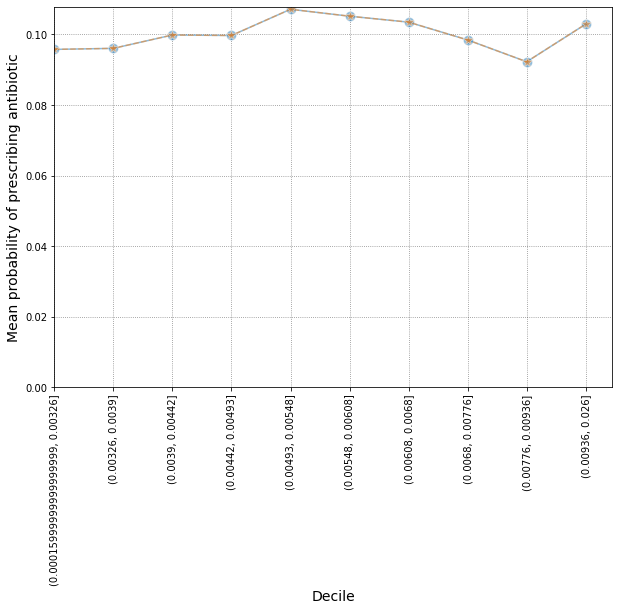


AUROC of LR for deciles with development and validation data: 0.50625 and 0.51412
AUROC of RF for deciles with development and validation data: 0.51331 and 0.51013
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00326, 0.0039]   0.112073  0.102568  0.122457
bins_(0.0039, 0.00442]   0.113152  0.103535  0.123663
bins_(0.00442, 0.00493]  0.115272  0.105543  0.125898
bins_(0.00493, 0.00548]  0.122296  0.112260  0.133230
bins_(0.00548, 0.00608]  0.120161  0.110144  0.131088
bins_(0.00608, 0.0068]   0.117327  0.107492  0.128061
bins_(0.0068, 0.00776]   0.109219  0.099818  0.119505
bins_(0.00776, 0.00936]  0.105923  0.096727  0.115994
bins_(0.00936, 0.026]    0.113376  0.103765  0.123878

RF feature importance:
                           rf_coef
bins_(0.00493, 0.00548]  0.210600
bins_(0.00548, 0.00608]  0.168530
bins_(0.00776, 0.00936]  0.144903
bins_(0.00608, 0.0068]   0.115694
bins_(0.0068, 0.00776]   0.083172
bins_(0.0039, 0.00442]   0.076502
bins_(0.00326,

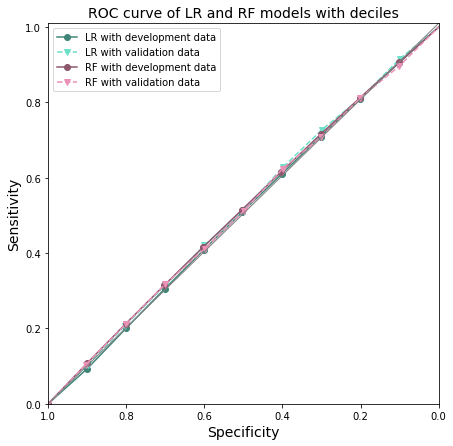

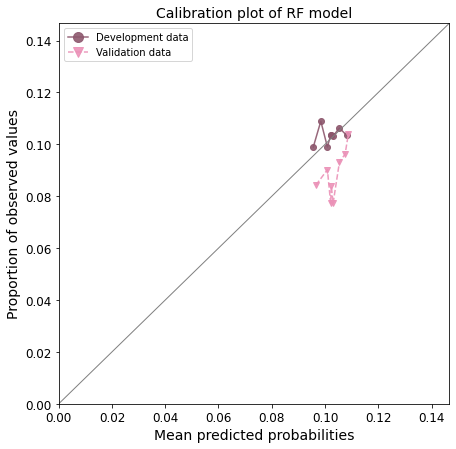

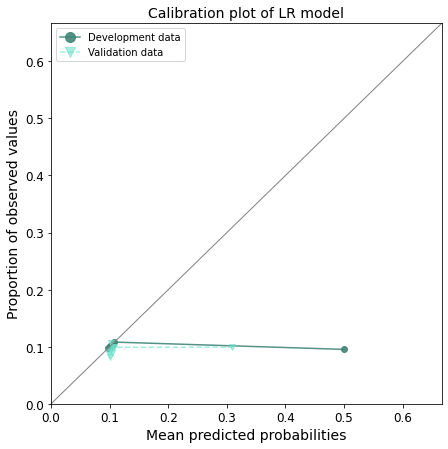

In [42]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt_post_2nd_lockdown, prob_pred_uti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown, data_uti_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('uti', 'incdt_post_2nd_lockdown_deciles', prob_pred_uti_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3241 total observations, 3223 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3241
number of events observed = 18
   partial log-likelihood = -120.40
         time fit was run = 2023-07-10 09:25:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.43       4.17       1.07            -0.66             3.52                 0.52                33.69
CCI_cat[T.medium]                0.37       1.44       1.24            -2.06             2.79                 0.13                16.32
CCI_cat[T.high]                  1.30       3.66       1.17            -0.99             3.59                 0.37                36.22
CCI_cat[T.very_high]             0.85       2.34       1.17            -1.44             3.15                 0.24                23.26
age_cat[T.25_34]                18.57   1.16e+08    5108.82         -9994.54         10031.68                 0.00                  inf
age_cat[T.35_44]                18.62   1.22e+08    5108.82         -9994.49         10031.73                 0.00                  inf
age_cat[T.45_54]                18.75   1.39e+08    5108.82         -9994.36         10031.86                 0.00                  inf
age_cat[T.55_64]                17.80   5.35e+07    5108.82         -9995.32         10030.91                 0.00                  inf
age_cat[T.65_74]                17.28   3.19e+07    5108.82         -9995.83         10030.39                 0.00                  inf
age_cat[T.75_more]              18.39   9.71e+07    5108.82         -9994.72         10031.50                 0.00                  inf
antibacterial_brit               0.15       1.16       0.17            -0.17             0.47                 0.84                 1.61
bmi_cat[T.obese]                -0.89       0.41       0.69            -2.25             0.47                 0.11                 1.59
bmi_cat[T.overweight]           -1.59       0.20       1.18            -3.91             0.73                 0.02                 2.08
bmi_cat[T.underweight]           0.09       1.09       1.20            -2.27             2.44                 0.10                11.45
bmi_cat[T.unknown]              -1.08       0.34       0.79            -2.64             0.47                 0.07                 1.60
ethnicity[T.other]              -0.33       0.72       1.04            -2.37             1.71                 0.09                 5.50
ethnicity[T.unknown]            -0.72       0.49       0.90            -2.48             1.04                 0.08                 2.83
ethnicity[T.white]              -0.65       0.52       0.80            -2.22             0.93                 0.11                 2.53
flu_vaccine[T.yes]              -0.73       0.48       1.06            -2.80             1.34                 0.06                 3.83
imd[T.medium]                  -17.23       0.00    5208.30        -10225.30         10190.85                 0.00                  inf
imd[T.unaffluent]              -17.13       0.00    5352.33        -10507.50         10473.24                 0.00                  inf
imd[T.unknown]                   2.43      11.41       1.18             0.13             4.74                 1.14               114.18
imd[T.very_affluent]             1.79       5.99       1.08            -0.32             3.90                 0.73                49.25
imd[T.very_unaffluent]           1.91       6.73       1.07            -0.20             4.01                 0.82                55.36
region[T.east_midlands]         -0.98       0.37       1.17            -3.2

13150


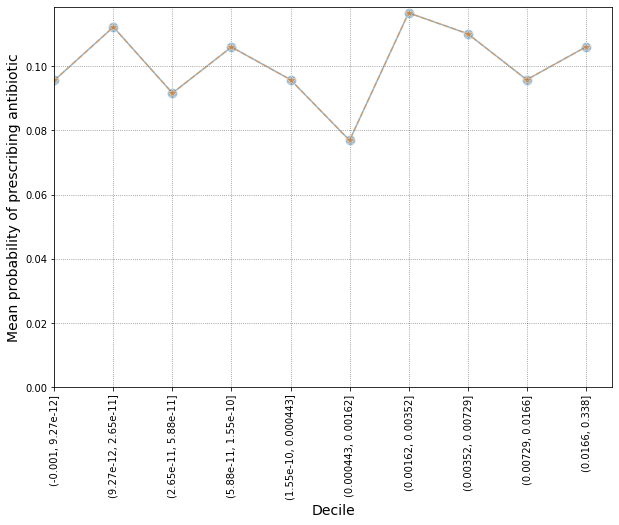


AUROC of LR for deciles with development and validation data: 0.53187 and 0.49883
AUROC of RF for deciles with development and validation data: 0.53618 and 0.51840
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(0.000443, 0.00162]   0.086420  0.058741  0.127140
bins_(0.00162, 0.00352]    0.124620  0.090077  0.172410
bins_(0.00352, 0.00729]    0.130573  0.094299  0.180802
bins_(0.00729, 0.0166]     0.097561  0.067863  0.140255
bins_(0.0166, 0.338]       0.118182  0.084805  0.164695
bins_(1.55e-10, 0.000443]  0.094955  0.066079  0.136450
bins_(2.65e-11, 5.88e-11]  0.108761  0.077107  0.153411
bins_(5.88e-11, 1.55e-10]  0.116279  0.081938  0.165012
bins_(9.27e-12, 2.65e-11]  0.130031  0.094281  0.179336

RF feature importance:
                             rf_coef
bins_(0.000443, 0.00162]   0.186557
bins_(0.00352, 0.00729]    0.125630
bins_(1.55e-10, 0.000443]  0.118434
bins_(9.27e-12, 2.65e-11]  0.116250
bins_(0.00162, 0.00352]    0.111156
bins_(0.00729, 0

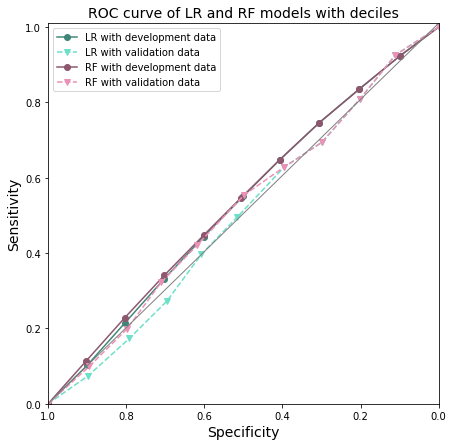

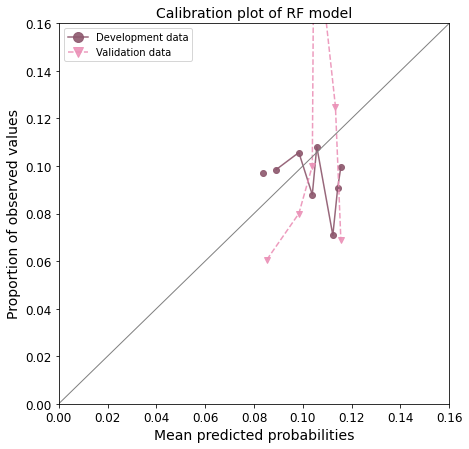

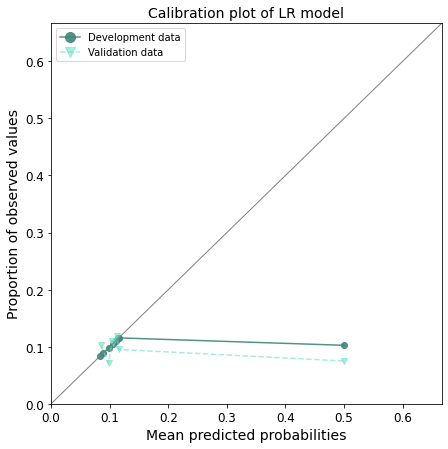

In [43]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl_prepandemic, prob_pred_uti_no_abs_prevl_prepandemic_bin = cox_build('uti', 'prevl_prepandemic', data_uti_prevl_prepandemic, data_uti_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('uti', 'prevl_prepandemic_deciles', prob_pred_uti_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3635 total observations, 3606 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3635
number of events observed = 29
   partial log-likelihood = -216.84
         time fit was run = 2023-07-10 09:25:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.29       0.60            -0.92             1.43                 0.40                 4.17
CCI_cat[T.medium]               -0.54       0.58       0.77            -2.04             0.97                 0.13                 2.64
CCI_cat[T.high]                 -0.25       0.78       0.87            -1.97             1.46                 0.14                 4.30
CCI_cat[T.very_high]             1.07       2.91       0.60            -0.11             2.24                 0.90                 9.42
age_cat[T.25_34]                -1.20       0.30       0.83            -2.82             0.42                 0.06                 1.52
age_cat[T.35_44]                -0.74       0.48       0.71            -2.14             0.66                 0.12                 1.94
age_cat[T.45_54]                -0.49       0.61       0.66            -1.77             0.80                 0.17                 2.22
age_cat[T.55_64]                -1.06       0.35       0.82            -2.68             0.56                 0.07                 1.74
age_cat[T.65_74]                 0.14       1.15       0.55            -0.94             1.22                 0.39                 3.39
age_cat[T.75_more]              -0.43       0.65       0.65            -1.71             0.85                 0.18                 2.34
antibacterial_brit              -0.04       0.96       0.14            -0.31             0.23                 0.74                 1.26
bmi_cat[T.obese]                 0.81       2.25       1.04            -1.23             2.86                 0.29                17.38
bmi_cat[T.overweight]            1.42       4.13       1.10            -0.74             3.57                 0.48                35.65
bmi_cat[T.underweight]         -16.11       0.00    4886.13         -9592.74          9560.53                 0.00                  inf
bmi_cat[T.unknown]               1.24       3.45       1.05            -0.83             3.30                 0.44                27.24
ethnicity[T.other]              -1.09       0.34       1.17            -3.39             1.21                 0.03                 3.34
ethnicity[T.unknown]            -0.18       0.83       0.69            -1.53             1.17                 0.22                 3.22
ethnicity[T.white]              -0.32       0.72       0.64            -1.57             0.93                 0.21                 2.53
flu_vaccine[T.yes]               0.05       1.05       0.62            -1.17             1.27                 0.31                 3.55
imd[T.medium]                   -0.95       0.39       0.61            -2.14             0.25                 0.12                 1.28
imd[T.unaffluent]               -0.64       0.53       0.57            -1.75             0.48                 0.17                 1.61
imd[T.unknown]                 -17.32       0.00    4183.46         -8216.75          8182.11                 0.00                  inf
imd[T.very_affluent]            -1.27       0.28       0.67            -2.58             0.05                 0.08                 1.05
imd[T.very_unaffluent]          -0.17       0.84       0.49            -1.14             0.80                 0.32                 2.22
region[T.east_midlands]         -1.23       0.29       1.12            -3.4

13075


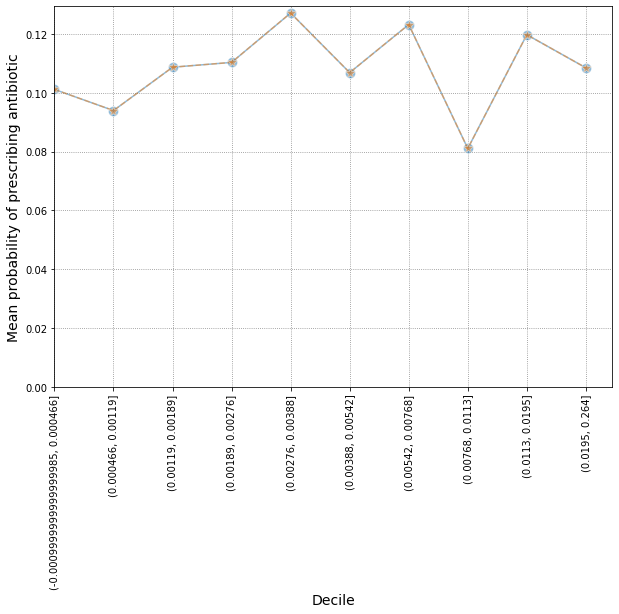


AUROC of LR for deciles with development and validation data: 0.53005 and 0.50946
AUROC of RF for deciles with development and validation data: 0.53953 and 0.52028
LR coefficients:
                                 OR  Lower CI  Upper CI
bins_(0.000466, 0.00119]  0.101828  0.073248  0.141559
bins_(0.00119, 0.00189]   0.125000  0.091039  0.171629
bins_(0.00189, 0.00276]   0.126685  0.093526  0.171599
bins_(0.00276, 0.00388]   0.144044  0.107706  0.192643
bins_(0.00388, 0.00542]   0.141274  0.105373  0.189407
bins_(0.00542, 0.00768]   0.152355  0.114722  0.202332
bins_(0.00768, 0.0113]    0.095109  0.067244  0.134520
bins_(0.0113, 0.0195]     0.147493  0.109602  0.198482
bins_(0.0195, 0.264]      0.130790  0.096812  0.176695

RF feature importance:
                            rf_coef
bins_(0.00768, 0.0113]    0.208484
bins_(0.000466, 0.00119]  0.158687
bins_(0.00542, 0.00768]   0.140290
bins_(0.0113, 0.0195]     0.105319
bins_(0.00276, 0.00388]   0.103425
bins_(0.00388, 0.00542]   0.0800

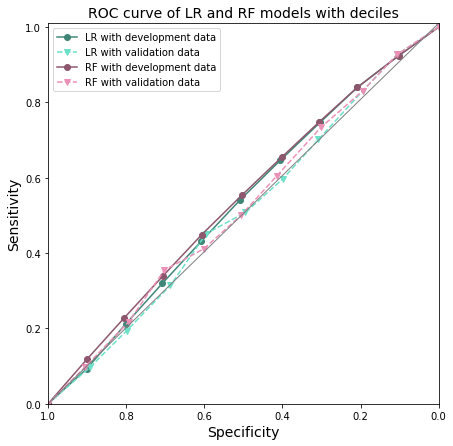

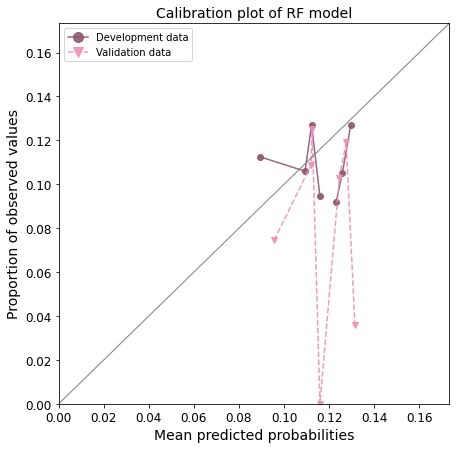

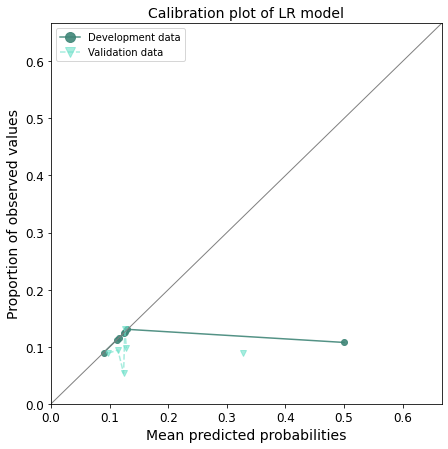

In [44]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl_during_pandemic, prob_pred_uti_no_abs_prevl_during_pandemic_bin = cox_build('uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic, data_uti_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('uti', 'prevl_during_pandemic_deciles', prob_pred_uti_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5309 total observations, 5270 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5309
number of events observed = 39
   partial log-likelihood = -317.95
         time fit was run = 2023-07-10 09:25:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.13       1.14       0.53            -0.91             1.17                 0.40                 3.22
CCI_cat[T.medium]                0.32       1.37       0.56            -0.78             1.42                 0.46                 4.13
CCI_cat[T.high]                 -0.26       0.77       0.74            -1.71             1.19                 0.18                 3.27
CCI_cat[T.very_high]             0.55       1.74       0.56            -0.55             1.65                 0.58                 5.23
age_cat[T.25_34]                -0.44       0.64       0.65            -1.71             0.83                 0.18                 2.30
age_cat[T.35_44]                 0.26       1.30       0.54            -0.81             1.33                 0.45                 3.78
age_cat[T.45_54]                -0.16       0.86       0.61            -1.35             1.04                 0.26                 2.82
age_cat[T.55_64]                -0.45       0.64       0.65            -1.73             0.83                 0.18                 2.29
age_cat[T.65_74]                -0.08       0.93       0.58            -1.21             1.06                 0.30                 2.89
age_cat[T.75_more]               0.02       1.02       0.58            -1.12             1.16                 0.33                 3.19
antibacterial_brit              -0.13       0.88       0.12            -0.36             0.11                 0.69                 1.11
bmi_cat[T.obese]                -0.20       0.82       0.55            -1.28             0.87                 0.28                 2.40
bmi_cat[T.overweight]           -1.00       0.37       0.87            -2.71             0.71                 0.07                 2.03
bmi_cat[T.underweight]           0.80       2.23       0.77            -0.71             2.31                 0.49                10.10
bmi_cat[T.unknown]              -0.54       0.58       0.62            -1.75             0.67                 0.17                 1.96
ethnicity[T.other]               0.69       1.99       0.72            -0.72             2.09                 0.49                 8.11
ethnicity[T.unknown]             0.18       1.20       0.66            -1.12             1.48                 0.33                 4.41
ethnicity[T.white]              -0.08       0.93       0.63            -1.30             1.15                 0.27                 3.16
flu_vaccine[T.yes]              -0.33       0.72       0.61            -1.52             0.85                 0.22                 2.35
imd[T.medium]                    0.65       1.91       0.56            -0.45             1.75                 0.64                 5.73
imd[T.unaffluent]                0.37       1.44       0.59            -0.79             1.52                 0.46                 4.57
imd[T.unknown]                   1.13       3.08       0.68            -0.20             2.45                 0.82                11.58
imd[T.very_affluent]            -0.20       0.82       0.67            -1.52             1.12                 0.22                 3.06
imd[T.very_unaffluent]           0.76       2.13       0.55            -0.32             1.84                 0.72                 6.27
region[T.east_midlands]         -0.61       0.54       1.23            -3.0

13040


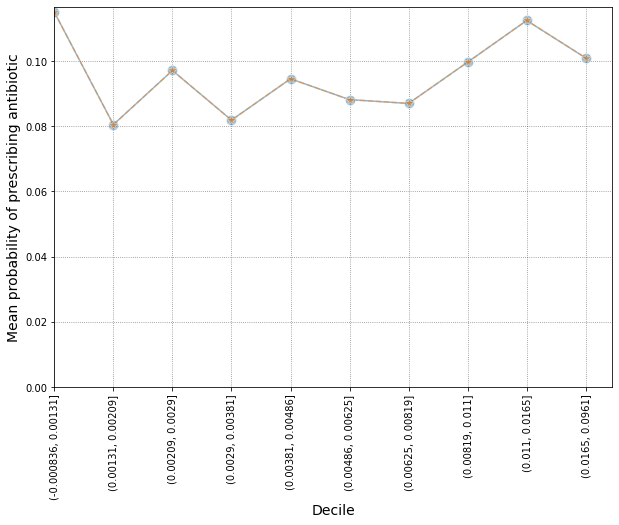


AUROC of LR for deciles with development and validation data: 0.53202 and 0.53559
AUROC of RF for deciles with development and validation data: 0.53185 and 0.53546
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00131, 0.00209]  0.092937  0.069557  0.124175
bins_(0.00209, 0.0029]   0.113106  0.087165  0.146767
bins_(0.0029, 0.00381]   0.088398  0.065806  0.118745
bins_(0.00381, 0.00486]  0.111324  0.084872  0.146021
bins_(0.00486, 0.00625]  0.089253  0.066637  0.119546
bins_(0.00625, 0.00819]  0.094340  0.070594  0.126073
bins_(0.00819, 0.011]    0.106796  0.080873  0.141028
bins_(0.011, 0.0165]     0.119318  0.091886  0.154941
bins_(0.0165, 0.0961]    0.105675  0.079831  0.139886

RF feature importance:
                           rf_coef
bins_(0.0029, 0.00381]   0.160776
bins_(0.00486, 0.00625]  0.145841
bins_(0.00131, 0.00209]  0.126326
bins_(0.00625, 0.00819]  0.116650
bins_(0.011, 0.0165]     0.115967
bins_(0.0165, 0.0961]    0.095561
bins_(0.00381,

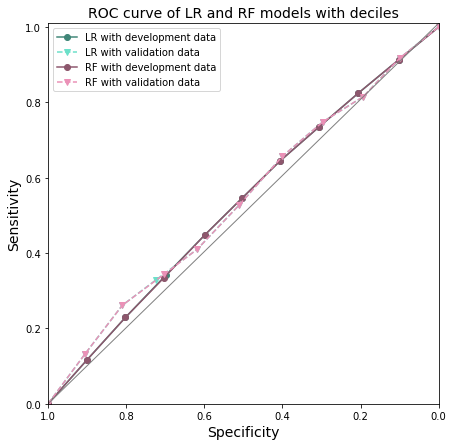

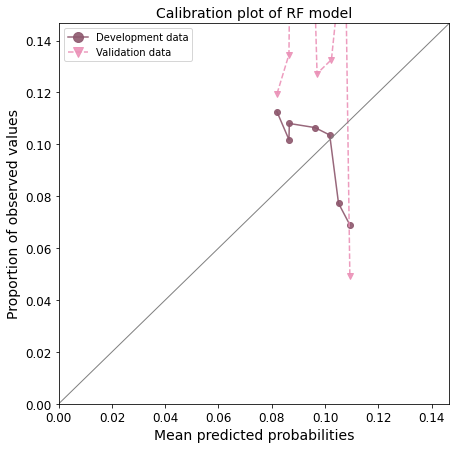

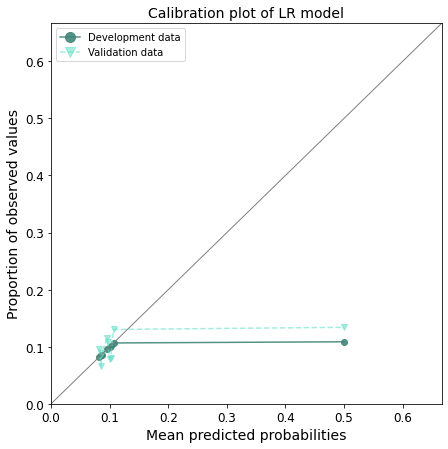

In [45]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl_post_2nd_lockdown, prob_pred_uti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown, data_uti_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('uti', 'prevl_post_2nd_lockdown_deciles', prob_pred_uti_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)